**Matheus Peixoto Ribeiro Vieira - 22.1.4104**

**Pedro Henrique Rabelo Leão de Oliveira - 22.1.4022**

In [2]:
import pandas as pd
import json
pd.set_option('display.max_columns', 100)

import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

from scipy.stats import gaussian_kde, norm

import seaborn as sns

# 0 - Formatando o dataset e adicionando novas colunas

In [2]:
!wget https://www.football-data.co.uk/new/BRA.csv -O ./data/BRA.csv

--2025-06-08 01:07:47--  https://www.football-data.co.uk/new/BRA.csv
Resolving www.football-data.co.uk (www.football-data.co.uk)... 217.160.0.246
Connecting to www.football-data.co.uk (www.football-data.co.uk)|217.160.0.246|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 560625 (547K) [text/csv]
Saving to: ‘./data/BRA.csv’

./data/BRA.csv      100%[===================>] 547.49K   523KB/s    in 1.0s    

2025-06-08 01:07:49 (523 KB/s) - ‘./data/BRA.csv’ saved [560625/560625]



| Atributo | Tipo do Atributo   | Descrição do Atributo |
|----------|------------------  |------------------------|
| Country  | Categórico nominal | Indica o país que a partida ocorreu |
| League   | Categórico nominal | Indica qual o campeonato em questão |
| Seasons  | Categórico nominal | Indica a temporada da partida |
| Date     | Categorico nominal | Data da partida
| Time     | Categorico nominal | Hora da partida
| Home     | Categórico nominal | ID único para o time mandante |
| Away     | Categórico nominal | ID único para o time visitante |
| HG       | Discreto           | Quantidade de gols do time mandante |
| AG       | Discreto           | Quantidade de gols do time visitante |
| Res      | Categórico nominal | Resultado da partida |
| PSCH     | Contínuo           | Odd de vitória do time mandante na Pinnacle Sports |
| PSCD     | Contínuo           | Odd de empate na Pinnacle Sports |
| PSCA     | Contínuo           | Odd de vitória do time visitante na Pinnacle Sports |
| MaxCH    | Contínuo           | Odd máxima de vitória do time mandante no mercado |
| MaxCD    | Contínuo           | Odd máxima de empate no mercado |
| MaxCA    | Contínuo           | Odd máxima de vitória do time visitante no mercado |
| AvgCH    | Contínuo           | Valor médio das odds para vitória do time mandante |
| AvgCD    | Contínuo           | Valor médio das odds para empate |
| AvgCA    | Contínuo           | Valor médio das odds para vitória do time visitante |
| BFECH    | Contínuo           | Odds da BetFair para vitória do time mandante
| BFECD    | Contínuo           | Odds da BetFair para empate
| BFECA    | Contínuo           | Odds da BetFair para vitória do time visitante

Transformando o nome dos times para valores numéricos, removendo as últimas três colunas que tem muitos valores vazios, acrescentando novas colunas com valores estatísticos sobre os times até aquela rodada do campeonato

In [3]:
def map_names_to_ids(df):
    """
        Receives a DataFrame with the Brasileirao data
        Combines all the teams' names from Home and Away and set them to an unique ID
    """
    # Combine both columns to get all unique names
    all_names = pd.concat([df['Home'], df['Away']]).unique()
    all_names = sorted(all_names)

    # Mapping the id to a name
    mapped_names = {name: i for i, name in enumerate(all_names)}
    df['Home'] = df['Home'].map(mapped_names)
    df['Away'] = df['Away'].map(mapped_names)

    return df, mapped_names

def save_mapped_ids(mapped_names, target_csv):
    # Saving the mapping of the teams IDs
    file_name = target_csv[:-4] + ".json"
    with open(file_name, "w") as file:
        json.dump(mapped_names, file, indent=4)


def add_new_columns(df: pd.DataFrame):
    for H_A in ["H", "A"]:
        df[f'W_{H_A}'] = 0
        df[f'D_{H_A}'] = 0
        df[f'L_{H_A}'] = 0
        df[f'GF_{H_A}'] = 0
        df[f'GA_{H_A}'] = 0
        df[f'GD_{H_A}'] = 0
    
    return df


def resetTeamStatisticsDict(mapped_names, teamStatistics):
    
    for idTeam in list(mapped_names.values()):
        teamStatistics[idTeam] = {
            'W': 0,  # Wons
            'D': 0,  # Drawn
            'L': 0,  # Loses
            'GF': 0, # Goals For
            'GA': 0, # Goals Against
            'GD': 0  # Goal Difference
        }


def updateStatistics(teamStatistics, home, away, goals_home, goals_away):
    """
        Function to update the team statistics with data from the previous round
    """

    teamStatistics[home]['GF'] += goals_home
    teamStatistics[home]['GA'] += goals_away
    teamStatistics[home]['GD'] += goals_home - goals_away

    teamStatistics[away]['GF'] += goals_away
    teamStatistics[away]['GA'] += goals_home
    teamStatistics[away]['GD'] += goals_away - goals_home

    if goals_home > goals_away:
        teamStatistics[home]['W'] += 1
        teamStatistics[away]['L'] += 1

    elif goals_away > goals_home:
        teamStatistics[home]['L'] += 1
        teamStatistics[away]['W'] += 1

    else:
        teamStatistics[home]['D'] += 1
        teamStatistics[away]['D'] += 1


def make_statistics(df: pd.DataFrame, mapped_names: dict):
    """

    """
    df = add_new_columns(df)

    teamStatistics = {}
    resetTeamStatisticsDict(mapped_names, teamStatistics)
    
    current_year = df.iloc[0]["Season"]
    
    for index, row in df.iterrows():
        if row["Season"] != current_year:
            current_year = row["Season"]
            resetTeamStatisticsDict(mapped_names, teamStatistics)
        
        home_id = row["Home"]
        away_id = row["Away"]
        
        # Saving the statistics from the season until the current game
        for h_a, id in [("H", home_id), ("A", away_id)]:
            for stat in ["W", "D", "L", "GF", "GA", "GD"]:
                df.loc[index, f"{stat}_{h_a}"] = teamStatistics[id][stat]



        # Updating statistics
        home_goals = row["HG"]
        away_goals = row["AG"]

        updateStatistics(teamStatistics, home_id, away_id, home_goals, away_goals)

    return df


def update_csv(original_csv, target_csv):
    """
        Receives the CSV file with the Brasileirao data
        Updates the columns 'Home' and 'Away' from nominal values to numerical.
        It will attribue an ID to each team
    """
    
    df = pd.read_csv(original_csv)

    df, mapped_names = map_names_to_ids(df)

    save_mapped_ids(mapped_names, target_csv)
    
    # Removing the last three columns which have many empty values
    df = df.drop(["Country", "League", "Date", "Time", "BFECH", "BFECD", "BFECA"], axis=1)
    
    
    df = make_statistics(df, mapped_names)
    
    df.to_csv(target_csv, index=False)


update_csv("data/BRA.csv", "data/BRA-modified.csv")

Remoção de Country e League que é igual para todos os atributos

Remoção de Date e Time que não são relevantes

Remoção de BFECH, BFECD e BFECA, pois a maioria de seus valores são nulos

# 1 - Análise descritiva dos atributos

In [3]:
df = pd.read_csv("./data/BRA-modified.csv")

## a) Descrição dos atributos

| Atributo | Tipo do Atributo | Descrição do Atributo |
|----------|------------------|------------------------|
| Seasons  | Categórico nominal         | Indica a temporada da partida |
| Home     | Categórico nominal | ID único para o time mandante |
| Away     | Categórico nominal | ID único para o time visitante |
| HG       | Discreto         | Quantidade de gols do time mandante |
| AG       | Discreto         | Quantidade de gols do time visitante |
| Res      | Categórico nominal | Resultado da partida |
| PSCH     | Contínuo         | Odd de vitória do time mandante na Pinnacle Sports |
| PSCD     | Contínuo         | Odd de empate na Pinnacle Sports |
| PSCA     | Contínuo         | Odd de vitória do time visitante na Pinnacle Sports |
| MaxCH    | Contínuo         | Odd máxima de vitória do time mandante no mercado |
| MaxCD    | Contínuo         | Odd máxima de empate no mercado |
| MaxCA    | Contínuo         | Odd máxima de vitória do time visitante no mercado |
| AvgCH    | Contínuo         | Valor médio das odds para vitória do time mandante |
| AvgCD    | Contínuo         | Valor médio das odds para empate |
| AvgCA    | Contínuo         | Valor médio das odds para vitória do time visitante |
| W_H      | Discreto         | Partidas vencidas pelo mandante antes da partida atual |
| D_H      | Discreto         | Partidas empatadas pelo mandante antes da partida atual |
| L_H      | Discreto         | Partidas perdidas pelo mandante antes da partida atual |
| GF_H     | Discreto         | Gols marcados pelo mandante antes da partida atual |
| GA_H     | Discreto         | Gols sofridos pelo mandante antes da partida atual |
| GD_H     | Discreto         | Diferença de gols do mandante antes da partida atual |
| W_A      | Discreto         | Partidas vencidas pelo visitante antes da partida atual |
| D_A      | Discreto         | Partidas empatadas pelo visitante antes da partida atual |
| L_A      | Discreto         | Partidas perdidas pelo visitante antes da partida atual |
| GF_A     | Discreto         | Gols marcados pelo visitante antes da partida atual |
| GA_A     | Discreto         | Gols sofridos pelo visitante antes da partida atual |
| GD_A     | Discreto         | Diferença de gols do visitante antes da partida atual |


## b) Descrição e visualização dos dados

In [4]:
categorical_data = ["Season", "Home", "Away", "Res"]
numerical_df = df.drop(categorical_data, axis=1)
numerical_df.describe()

HG           AG         PSCH        PSCD         PSCA  \
count  5049.000000  5049.000000  5049.000000  5049.00000  5049.000000   
mean      1.412953     0.959992     2.308303     3.63712     4.673791   
std       1.157556     0.976742     0.947766     0.65191     2.461673   
min       0.000000     0.000000     1.080000     2.54000     1.150000   
25%       1.000000     0.000000     1.700000     3.24000     2.990000   
50%       1.000000     1.000000     2.080000     3.45000     4.030000   
75%       2.000000     2.000000     2.620000     3.84000     5.700000   
max       7.000000     6.000000    17.680000    12.25000    29.580000   

             MaxCH        MaxCD        MaxCA        AvgCH        AvgCD  \
count  5050.000000  5050.000000  5050.000000  5050.000000  5050.000000   
mean      2.388065     3.742943     4.915984     2.234867     3.485139   
std       1.049022     0.678619     2.726412     0.882996     0.570132   
min       1.090000     2.630000     0.000000     1.070000     2.510000   
25%       1.750000     3.330000     3.060000     1.670000     3.150000   
50%       2.150000     3.530000     4.160000     2.030000     3.300000   
75%       2.700000     3.950000     6.000000     2.537500     3.660000   
max      29.000000    12.500000    36.000000    20.230000    10.820000   

             AvgCA          W_H          D_H          L_H         GF_H  \
count  5050.000000  5050.000000  5050.000000  5050.000000  5050.000000   
mean      4.328808     6.552871     4.989901     6.661782    21.471485   
std       2.123866     4.863199     3.482591     4.877674    14.548601   
min       1.150000     0.000000     0.000000     0.000000     0.000000   
25%       2.860000     3.000000     2.000000     3.000000     9.000000   
50%       3.760000     6.000000     5.000000     6.000000    20.000000   
75%       5.280000    10.000000     7.000000    10.000000    32.000000   
max      26.580000    27.000000    17.000000    28.000000    80.000000   

              GA_H         GD_H          W_A          D_A          L_A  \
count  5050.000000  5050.000000  5050.000000  5050.000000  5050.000000   
mean     21.683762    -0.212277     6.662178     4.979406     6.565743   
std      14.381925    10.054776     4.872095     3.479102     4.871627   
min       0.000000   -58.000000     0.000000     0.000000     0.000000   
25%      10.000000    -5.000000     3.000000     2.000000     2.000000   
50%      20.000000     0.000000     6.000000     5.000000     6.000000   
75%      32.000000     5.000000    10.000000     7.000000    10.000000   
max      79.000000    48.000000    28.000000    17.000000    27.000000   

              GF_A         GA_A         GD_A  
count  5050.000000  5050.000000  5050.000000  
mean     21.680198    21.481980     0.198218  
std      14.571591    14.367891    10.082847  
min       0.000000     0.000000   -56.000000  
25%       9.000000     9.000000    -5.000000  
50%      20.000000    20.000000     0.000000  
75%      32.000000    32.000000     5.000000  
max      86.000000    80.000000    53.000000

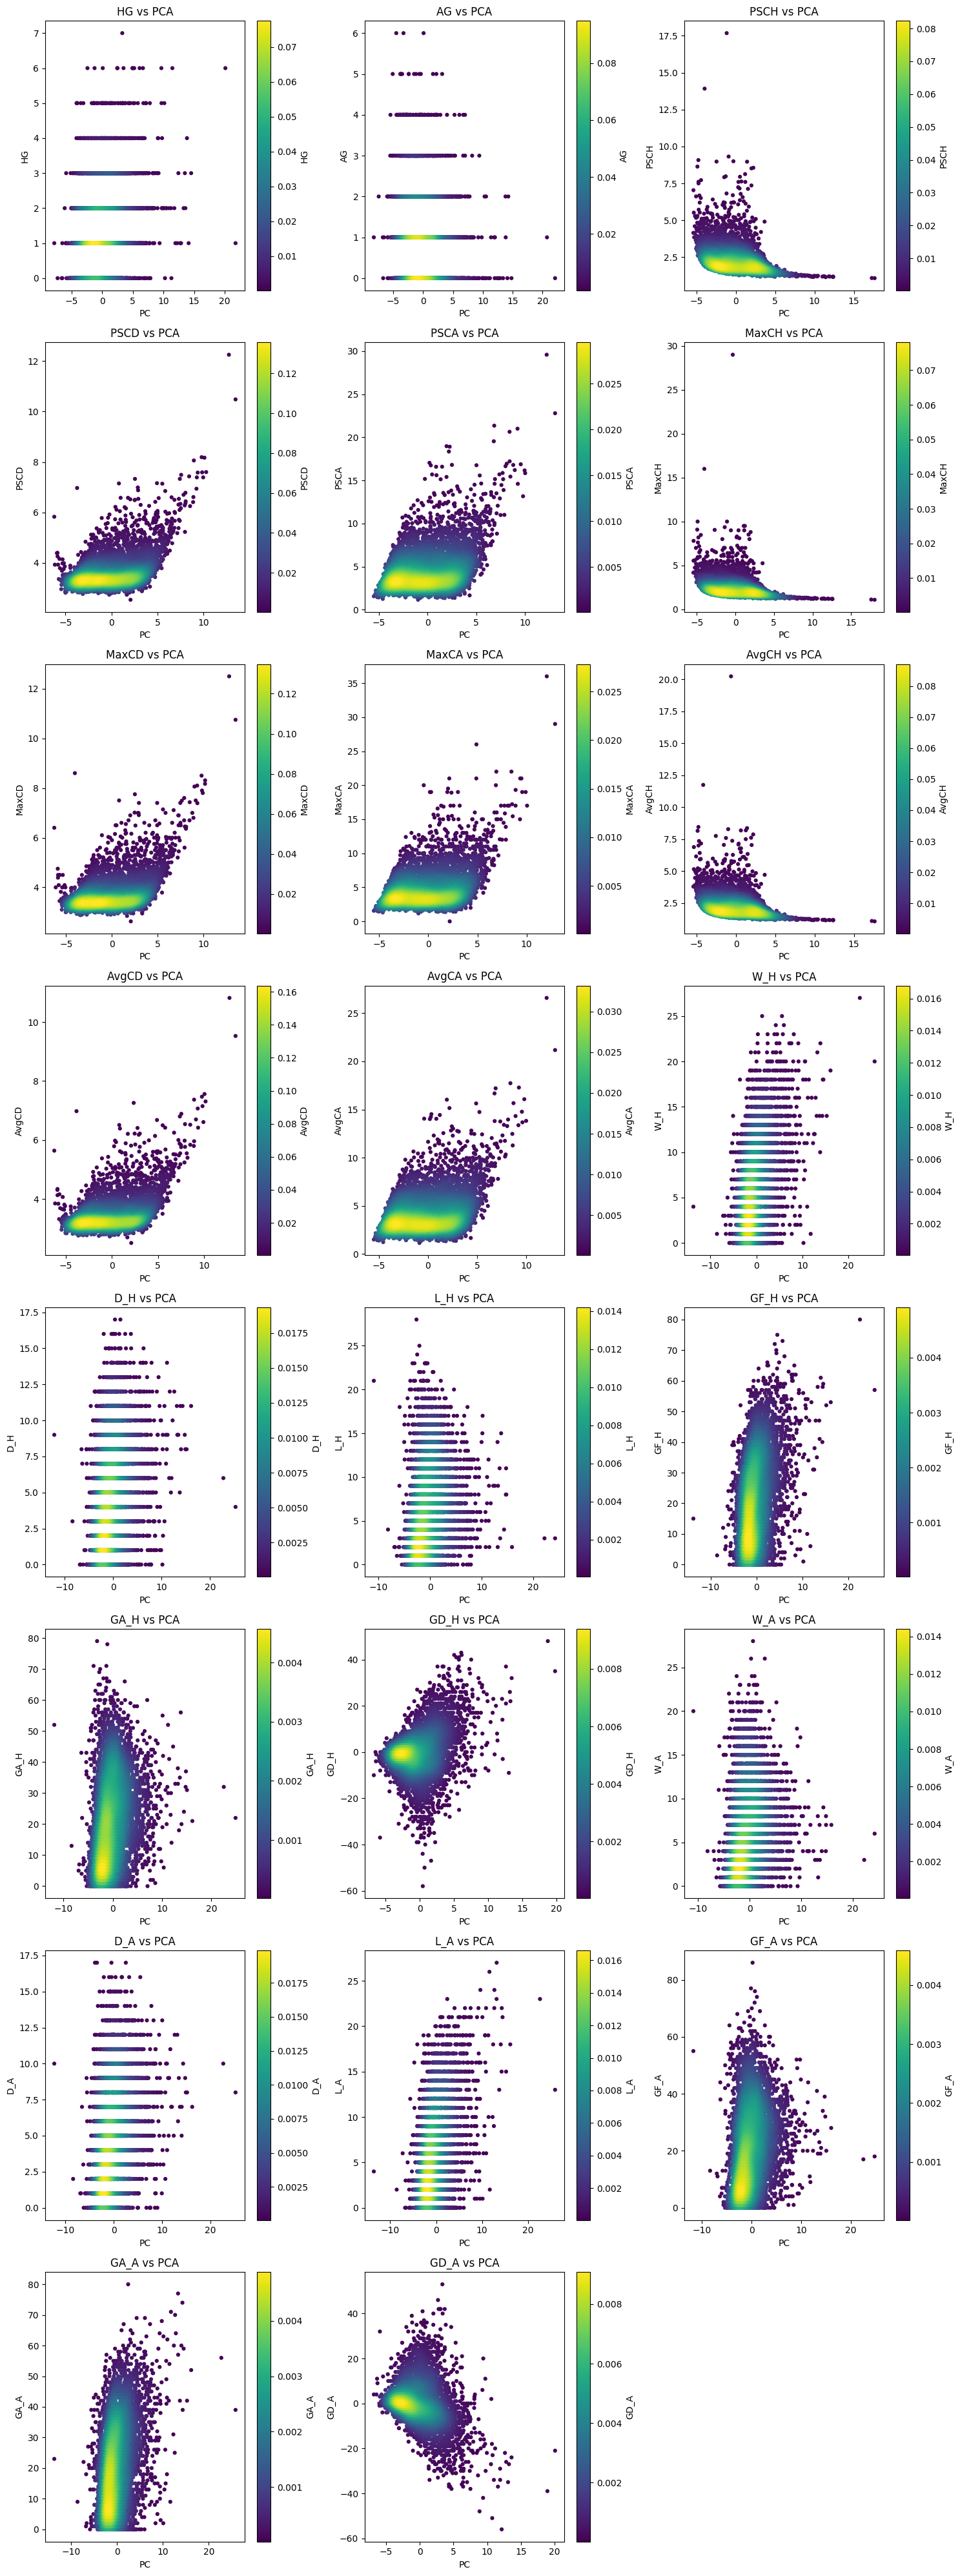

In [7]:
def plot_pca(df):
    total_cols = len(df.columns)
    n_cols = 3
    n_rows = ((total_cols) + n_cols - 1) // n_cols
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 5 * n_rows))
    axes = axes.flatten()

    for idx, col in enumerate(df.columns):   
        
        temp_df = df.drop(col, axis=1)
        
        scaler = StandardScaler()
        X_scaled = scaler.fit_transform(temp_df)
        
        pca = PCA(n_components=1)
        X = pca.fit_transform(X_scaled)

        # Calculating the data density
        x = X.ravel()
        y = df[col].values
        xy = np.vstack([x, y])
        z = gaussian_kde(xy)(xy) 
        i = z.argsort()
        x, y, z = x[i], y[i], z[i]

        ax = axes[idx]
        sc = ax.scatter(x, y, c=z, s=20, cmap="viridis", edgecolor="none")
        ax.set_title(f'{col} vs PCA')
        ax.set_xlabel("PC")
        ax.set_ylabel(col)
        plt.colorbar(sc, ax=ax, label=col)

    # Remove unused subplots if any
    for j in range(idx + 1, len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout()
    plt.show()

plot_pca(numerical_df.drop(1891))

O PCA mostra a relação dos demais atributos em relação ao comparado atualmente. Com a sua visualização, percebe-se que uma regressão linear simples pode não ser tão eficiente, mesmo para a suavização de ruídos em etapas futuras do projeto

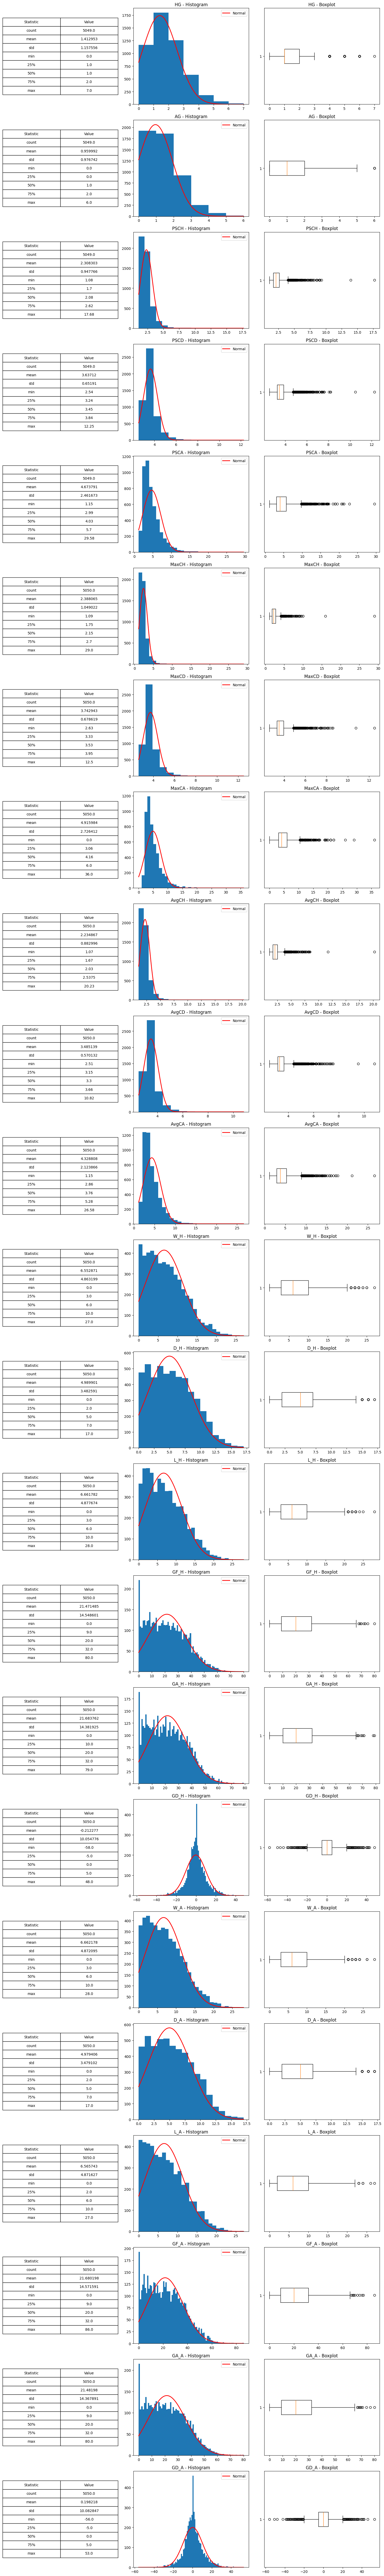

In [ ]:
def describe_histogram_boxplot(df):
    n_attributes = len(df.columns)
    fig, axes = plt.subplots(n_attributes, 3, figsize=(15, 100))
    axes = axes.reshape(n_attributes, 3)  # reshape to 2D array [rows][cols]

    boxplots = {}

    for idx, attribute in enumerate(numerical_df.columns):
        # Table
        ax_table = axes[idx][0]
        ax_table.axis("off")
        
        stats = df[attribute].describe().to_dict()
        stats = {k: round(v, 6) for k, v in stats.items()}
        table_data = [[k, str(v)] for k, v in stats.items()]

        table = ax_table.table(cellText=table_data, colLabels=["Statistic", "Value"], loc='center', cellLoc="center")
        table.scale(1, 1.5)
        for _, cell in table.get_celld().items():
            cell.set_fontsize(10)

        # Histogram
        ax_hist = axes[idx][1]
        data = df[attribute].dropna()
        
        bins = int(abs(data.min()) + data.max())
        _, bin_edges, _ = ax_hist.hist(data, bins=bins)
        ax_hist.set_title(f"{attribute} - Histogram")
        
        # Adding normal distribution on the histogram
        mu, sigma = data.mean(), data.std(ddof=0)
        x = np.linspace(data.min(), data.max(), 500)
        pdf = norm.pdf(x, loc=mu, scale=sigma)
        bin_width = bin_edges[1] - bin_edges[0]
        normal_curve = pdf * len(data) * bin_width
        ax_hist.plot(x, normal_curve, color="red", lw=2, label="Normal")  
        ax_hist.legend()                                                   

        # Boxplot
        ax_box = axes[idx][2]
        bp = ax_box.boxplot(df[attribute].dropna(), vert=False, whis=1.5)
        ax_box.set_title(f"{attribute} - Boxplot")

        Q1 = df[attribute].quantile(0.25)
        Q3 = df[attribute].quantile(0.75)
        AIQ = Q3 - Q1

        boxplots[attribute] = {
            "min": bp["whiskers"][0].get_xdata()[1], 
            "max": bp["whiskers"][1].get_xdata()[1],
            "Q1": Q1,
            "Q3": Q3,
            "AIQ": AIQ 
        }

    plt.tight_layout()
    plt.show()

    return boxplots

boxplots = describe_histogram_boxplot(numerical_df)

Percebemos que todos os dados que representam odds de casas de apostas e os dados que representam saldo de gols (GD - goals difference) apresentam uma grande quantidade de outliers. 

No caso das odds definidas pelas casas de aposta, os valores dificilmente são maiores que 3, uma vez que o campeonato brasileiro é um dos mais equilibrados do mundo. Entretanto, se juntarmos todas as partidas que ocorreram de 2012 até hoje, encontramos algumas que existe um favoritismo grande de um time para outro, por exemplo quando um time com um alto investimento enfrenta um que subiu da série B naquele ano. Portanto, a quantidade grande de outliers nesses atributos pode ser explicada pelo fato de que quando um valor de odd sai do intervalo entre aproximadamente 1 e 3 já é considerado uma exceção quando comparado com a maioria das partidas nesse período de 13 anos e 6 meses. 
Podemos confirmar essas informações pelos histogramas referentes a esses atributos, que tem sempre um concentração maior nesse intervalo, variando para valores mais baixos quando se trata de times da casa e para valores um pouco maiores quando se trata de empate e de times de fora, já que no geral existe sempre um leve favoritismo para os times que estão jogando em seu estádio ao lado de sua torcida. 

Já para o caso do saldo de gols dos times, nós encontramos uma média que não distoa muito de 0 que representa os times mais centralizados na tabela do campeonato, porém todo ano temos os times do topo e os times que serão rebaixados que acabam tendo um saldo de gols diferentes dos demais, tanto para positivamente, já que os times do topo sofrem poucos gols e fazem muitos, quanto para negativamente, já que os times da parte inferior da tabela costumam sofrer muitos gols e fazer poucos.

Quando olhamos para os gols feitos pelos times da casa e de fora, podemos ver tanto pelo boxplot, quando pelo histograma e pela tabela de informações que dificilmente os times fazem mais que 3 gols em uma partida, mas diferente das odds e da diferença de gols, praticamente todos os dados seguem esse padrão e os casos em que vemos os times fazendo um número de gols diferentes são extremamente raros. Não é por acaso que a partir de 3 gols, os expectadores de futebol já consideram goleada, porque não é algo comum de se ver.

Pros casos dos números de vitórias, de empates e de derrotas dos times no campeonato, esses são valores extremamente variados, principalmente pela forma que temos nossos dados organizados. Em cada amostra, que representa uma partida, temos esses números calculados apenas até aquela respectiva rodada da temporada, portanto, além da variação esperadas desses números entre os times, existe a variação para cada rodada das 14 temporadas abordadas nesse dataset. Com isso, o limite inferior e superior dos boxplots tem um intervalo maior, ocasionando também em menos valores considerados outliers.

## c) Valores possíveis para atributos nominais e suas distribuições de probabilidades

In [5]:
for attribute in categorical_data:
    print(f"{df[attribute].value_counts(normalize=True)}")
    print("\n")

Season
2012    0.075248
2013    0.075248
2014    0.075248
2015    0.075248
2016    0.075248
2017    0.075248
2018    0.075248
2019    0.075248
2020    0.075248
2021    0.075248
2022    0.075248
2023    0.075248
2024    0.075248
2025    0.021782
Name: proportion, dtype: float64


Home
17    0.050099
33    0.050099
11    0.050099
18    0.049901
3     0.049901
21    0.046337
32    0.046139
27    0.046139
22    0.046139
1     0.045149
6     0.042376
14    0.038812
5     0.038812
35    0.035050
12    0.033861
34    0.031089
10    0.026337
20    0.026337
36    0.023564
19    0.023564
2     0.022574
9     0.020000
7     0.020000
29    0.018812
0     0.018812
16    0.015050
4     0.015050
15    0.015050
24    0.012475
13    0.011287
30    0.007525
26    0.007525
8     0.003762
28    0.003762
31    0.003762
23    0.003762
25    0.000990
Name: proportion, dtype: float64


Away
18    0.050099
3     0.050099
33    0.049901
17    0.049901
11    0.049901
22    0.046337
27    0.046337
32    0.046337


[]

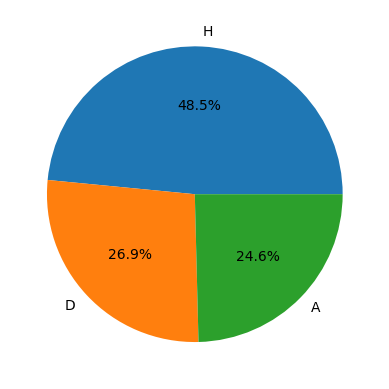

In [16]:
x = df["Res"].value_counts(normalize=True).values
labels = df["Res"].value_counts(normalize=True).keys() 
plt.pie(x, labels=labels, autopct='%1.1f%%')
plt.plot()

Os dados de season aparecem de forma semelhante pois as temporadas possuem valores iguais de partidas

Home e Away irão variar devido ao rebaixamento dos times durante o período de tempo

Por outro lado, é interessante ver que os times que jogaram como mandantes possuem um maior aproveitamento das partidas

## d) Identificação de valores ausentes, aberrantes e inconsistentes
O dataset, antes de passar por este notebook é pré-processasdo no início desse arquivo, onde algumas colunas são removidas devido à grande quantidade de valores nulos e pela grande dificuldade que seria para gerar novos valores, uma vez que a quantidade de linhas não nulas são muito baixas. Essas colunas são: "BFECH", "BFECD", "BFECA".

In [10]:
def check_null_itens(df):
    for index, value in df.isnull().any().items():    
        if value:
            print(f"{index} contains {df[index].isnull().sum()} null values")

check_null_itens(df)

HG contains 1 null values
AG contains 1 null values
Res contains 1 null values
PSCH contains 1 null values
PSCD contains 1 null values
PSCA contains 1 null values


Após uma investigação, descobriu-se que os valores nulos correspondem a uma partida da última rodada do campeonato Brasileiro do ano de 2016, entre Chapecoense e Atlético-MG, no dia 11/12/2016. A inexistência dos valores deve-se ao fato de que a partida não aconteceu, e ambas as equipes sofreram um [WO duplo](https://www.uol.com.br/esporte/futebol/campeonatos/brasileiro/serie-a/ultimas-noticias/2016/12/11/chapecoense-x-atletico-mg.htm).

In [11]:
for attribute in numerical_df:
    values = df[attribute].dropna()
    lower_bound = boxplots[attribute]["min"]
    upper_bound = boxplots[attribute]["max"]

    outliers = values[(values < lower_bound) | (values > upper_bound)]

    print(f"Outliers in {attribute}:")
    print(lower_bound, upper_bound)
    print(outliers)
    print("-" * 40)

Outliers in HG:
0.0 3.0
3       4.0
24      4.0
42      4.0
52      5.0
74      4.0
       ... 
4995    4.0
5002    4.0
5010    5.0
5018    4.0
5046    5.0
Name: HG, Length: 250, dtype: float64
----------------------------------------
Outliers in AG:
0.0 5.0
1948    6.0
4430    6.0
4619    6.0
Name: AG, dtype: float64
----------------------------------------
Outliers in PSCH:
1.08 4.0
290     4.78
333     4.94
340     5.19
365     4.92
414     4.05
        ... 
4987    4.40
5006    6.68
5007    4.85
5025    4.11
5026    4.04
Name: PSCH, Length: 252, dtype: float64
----------------------------------------
Outliers in PSCD:
2.54 4.73
16      4.76
17      4.74
24      4.99
52      5.09
76      5.09
        ... 
4933    5.01
4935    5.20
4976    6.58
4990    4.77
5046    5.10
Name: PSCD, Length: 316, dtype: float64
----------------------------------------
Outliers in PSCA:
1.15 9.74
52      10.75
134     12.11
190     10.72
238     11.05
247     11.09
        ...  
4881    14.61
4929    10

## e) Correlação dos atributos numéricos

In [12]:
temp_df = df.copy()

temp_df["Res"] = temp_df["Res"].map({"H": 1, "D": 0, "A": -1})
temp_df = temp_df.drop(["Season", "Home", "Away"], axis=1)

correlations = temp_df.corr(method='pearson')
correlations

HG        AG       Res      PSCH      PSCD      PSCA     MaxCH  \
HG     1.000000  0.022850  0.610100 -0.233991  0.238623  0.259717 -0.221819   
AG     0.022850  1.000000 -0.608991  0.197018 -0.071332 -0.167203  0.187459   
Res    0.610100 -0.608991  1.000000 -0.286371  0.176569  0.264267 -0.271699   
PSCH  -0.233991  0.197018 -0.286371  1.000000 -0.332362 -0.664378  0.986802   
PSCD   0.238623 -0.071332  0.176569 -0.332362  1.000000  0.851667 -0.296907   
PSCA   0.259717 -0.167203  0.264267 -0.664378  0.851667  1.000000 -0.630763   
MaxCH -0.221819  0.187459 -0.271699  0.986802 -0.296907 -0.630763  1.000000   
MaxCD  0.237945 -0.076307  0.180661 -0.329498  0.986364  0.857607 -0.291075   
MaxCA  0.260116 -0.162425  0.262066 -0.647914  0.859406  0.988119 -0.616911   
AvgCH -0.232331  0.194852 -0.283517  0.995406 -0.332886 -0.661903  0.993786   
AvgCD  0.238480 -0.074873  0.179548 -0.325986  0.986729  0.860038 -0.290165   
AvgCA  0.264969 -0.168140  0.269525 -0.674691  0.850840  0.991894 -0.642485   
W_H    0.099627 -0.037727  0.081852 -0.214775  0.278500  0.261919 -0.207418   
D_H    0.003852 -0.010159  0.003957  0.008861  0.041019  0.012186  0.011741   
L_H   -0.071924  0.036403 -0.083535  0.209776 -0.064831 -0.186478  0.208896   
GF_H   0.075553 -0.020008  0.054247 -0.156900  0.256610  0.198232 -0.151238   
GA_H  -0.039481  0.033517 -0.057585  0.136476  0.019064 -0.111629  0.136324   
GD_H   0.165730 -0.076860  0.160794 -0.422067  0.343916  0.446328 -0.413824   
W_A   -0.048679  0.060521 -0.073605  0.213525 -0.064153 -0.200231  0.213493   
D_A    0.002924 -0.021947  0.014865 -0.002061  0.055076  0.028732 -0.000357   
L_A    0.076134 -0.050821  0.060573 -0.212392  0.266205  0.263942 -0.205269   
GF_A  -0.022211  0.056835 -0.056531  0.159582  0.005884 -0.141868  0.160079   
GA_A   0.061393 -0.020640  0.034325 -0.133983  0.238877  0.182399 -0.127659   
GD_A  -0.119539  0.111491 -0.130548  0.421357 -0.331803 -0.464745  0.413255   

          MaxCD     MaxCA     AvgCH     AvgCD     AvgCA       W_H       D_H  \
HG     0.237945  0.260116 -0.232331  0.238480  0.264969  0.099627  0.003852   
AG    -0.076307 -0.162425  0.194852 -0.074873 -0.168140 -0.037727 -0.010159   
Res    0.180661  0.262066 -0.283517  0.179548  0.269525  0.081852  0.003957   
PSCH  -0.329498 -0.647914  0.995406 -0.325986 -0.674691 -0.214775  0.008861   
PSCD   0.986364  0.859406 -0.332886  0.986729  0.850840  0.278500  0.041019   
PSCA   0.857607  0.988119 -0.661903  0.860038  0.991894  0.261919  0.012186   
MaxCH -0.291075 -0.616911  0.993786 -0.290165 -0.642485 -0.207418  0.011741   
MaxCD  1.000000  0.868257 -0.329507  0.987978  0.858567  0.279180  0.039230   
MaxCA  0.868257  1.000000 -0.647582  0.870007  0.991118  0.267418  0.009601   
AvgCH -0.329507 -0.647582  1.000000 -0.325975 -0.673591 -0.214814  0.013234   
AvgCD  0.987978  0.870007 -0.325975  1.000000  0.865737  0.281654  0.043959   
AvgCA  0.858567  0.991118 -0.673591  0.865737  1.000000  0.270022  0.014302   
W_H    0.279180  0.267418 -0.214814  0.281654  0.270022  1.000000  0.612486   
D_H    0.039230  0.009601  0.013234  0.043959  0.014302  0.612486  1.000000   
L_H   -0.079215 -0.187485  0.213611 -0.074951 -0.190798  0.445732  0.599749   
GF_H   0.254189  0.202054 -0.156142  0.257754  0.204447  0.940842  0.722861   
GA_H   0.006924 -0.110968  0.139527  0.011438 -0.113354  0.603956  0.732068   
GD_H   0.357890  0.451082 -0.425500  0.356593  0.457959  0.497463 -0.001187   
W_A   -0.075498 -0.198072  0.218129 -0.070431 -0.202366  0.685017  0.695593   
D_A    0.054890  0.030062  0.000228  0.057954  0.032482  0.707125  0.729266   
L_A    0.263124  0.263642 -0.211900  0.265703  0.268870  0.688939  0.707137   
GF_A  -0.004514 -0.139659  0.163151  0.000502 -0.141653  0.740083  0.756978   
GA_A   0.232939  0.182436 -0.132435  0.236459  0.185865  0.752484  0.774486   
GD_A  -0.338458 -0.461801  0.424502 -0.336225 -0.469570 -0.002720 -0.009656   

            L_H      GF_H      GA_H      GD_H       W_A      

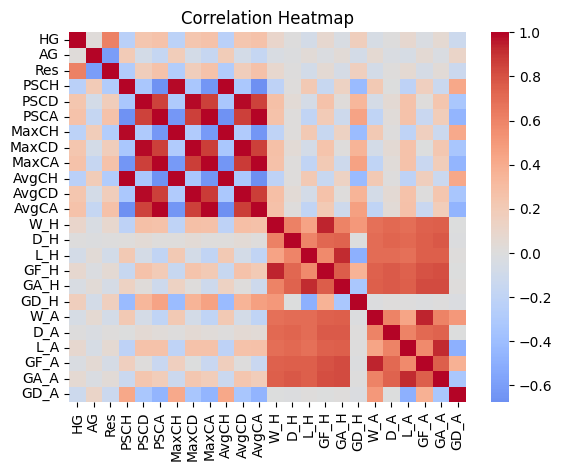

In [13]:
sns.heatmap(correlations, annot=False, cmap='coolwarm', center=0)
plt.title("Correlation Heatmap")
plt.show()

In [14]:
weak_correlations = {}
for index_row, row in correlations.iterrows():
    for index_col in row.keys():
        if -0.2 < row[index_col] < 0.2:

            if index_row not in weak_correlations:
                weak_correlations[index_row] = []
            
            correlation = {index_col: row[index_col]}
            weak_correlations[index_row].append(correlation)


strong_correlations = {}
for index_row, row in correlations.iterrows():
    for index_col in row.keys():
        if (0.8 < row[index_col] < 1.0) or (-1.0 < row[index_col] < -0.8):

            if index_row not in strong_correlations:
                strong_correlations[index_row] = []
            
            correlation = {index_col: row[index_col]}
            strong_correlations[index_row].append(correlation)

print(weak_correlations)
print("")
print(strong_correlations)

{'HG': [{'AG': 0.022850277086637834}, {'W_H': 0.09962717941554795}, {'D_H': 0.0038524664096294885}, {'L_H': -0.07192435956075498}, {'GF_H': 0.07555322161466108}, {'GA_H': -0.03948122303838603}, {'GD_H': 0.16572984550300246}, {'W_A': -0.0486788523936254}, {'D_A': 0.002923650343487241}, {'L_A': 0.07613386767893285}, {'GF_A': -0.022210504643411573}, {'GA_A': 0.0613931011320837}, {'GD_A': -0.11953875599859128}], 'AG': [{'HG': 0.022850277086637834}, {'PSCH': 0.19701839341837404}, {'PSCD': -0.07133165329776624}, {'PSCA': -0.1672026570380912}, {'MaxCH': 0.1874587727155394}, {'MaxCD': -0.07630712016642846}, {'MaxCA': -0.1624249600466679}, {'AvgCH': 0.19485186247772254}, {'AvgCD': -0.07487343642198416}, {'AvgCA': -0.1681397584646134}, {'W_H': -0.0377274420695981}, {'D_H': -0.010158533623878942}, {'L_H': 0.03640309723226863}, {'GF_H': -0.02000785480784105}, {'GA_H': 0.033517138627048526}, {'GD_H': -0.07685983701121087}, {'W_A': 0.06052083408564971}, {'D_A': -0.021946742408234177}, {'L_A': -0.050

Consideramos uma correlação forte quando o valor é maior que 0.8, visto que esse valor sugere que uma variável pode agregar a mesma informação que a outra dentro de um modelo.

Podemos observar que os três tipos de atributos de odds de casa de aposta presentes no dataset, odds da Pinnacle Sports, odds máximas do mercado e valores médios das odds no mercado, têm uma forte correlação tanto para o caso de vitória do time mandante, quanto para o caso de empate e para o caso de vitória do time visitante. Isso significa, por exemplo, que quanto maior o valor da odd da Pinnacle Sports para a vitória do time mandante, maior a odd máxima e o valor médio da odd no mercado para a vitória do mandante. Isso, no caso, é um comportamento esperado, já que as odds seguem um padrão por analisarem o mesmo contexto de campeonato. Portanto, manter apenas um dos tipos de odd pode ser suficiente para trazer a informação ao modelo do que é esperado para aquela partida pelas casas de aposta.

Da mesma forma, podemos observar uma correlação forte entre os atributos de números de vitórias do time e número de gols feitos por ele, e entre os atributos de números de derrotas do time e números de gols sofridos por ele, tanto no caso do time mandante, quanto no caso do time visitante. Isso é explicado pelo fato de que se espera que times que venceram mais tenham também marcado mais gols, e times que tiveram mais derrotas também tenham sofrido mais gols.

Por fim, vemos uma correlação forte aparecendo entre o número de gols feitos pelo mandante da partida e gols feitos e sofridos pelo visitante. E o mesmo para o contrário. Isso ocorre pela organização do nosso dataset, em que cada rodada apresentam dados estatísticos dos dois times até aquele momento do campeonato. Logo, é normal que a cada rodada, o número de gols feitos e sofridos de ambos os times crescam, trazendo uma correlação para esses 4 atributos. 

Para uma correlação fraca, temos atributos que não tem dependência um com outro. Podemos perceber por exemplo que o número de gols marcados pelo time mandante e pelo time visitante na partida tem correlação fraca com a maioria das outras variáveis. Isso porque o número de gols feitos por eles não é necessariamente explicado por nenhuma delas isoladamente.

# 2 - Limpeza e transformação dos dados

## a) Removendo valores nulos
O dado de index 1891 corresponde à partida entre Chapecoense e Atlético-MG (Galo) que não ocorreu, como já foi explicado na letra D da parte 1. Por isso tal partida será removida do conjunto de dados

In [15]:
df = df.drop(1891)
check_null_itens(df) # if no print is made, then there is no null values

## b) Suavização de ruídos

O uso de regressão linear para a normalização não gerou resultados satisfatórios, mantendo outliers ainda muito altos

Utilizando a regra de Freedman-Diaconis para determinar o número de bins, que diminui a chance dos dados se transformarem em uma distribuição normal, como ocorre na regra de Scott

$$
\text{Number of bins} = \frac{\max(x) - \min(x)}{2 \cdot {IQR} \cdot {n^{-1/3}}}
$$

In [16]:
def freedman_diaconis_rule(data, iqr):
    data = data.to_numpy()
    num_bins = int((data.max()-data.min()) / (2*iqr*len(data)**(-1/3)))
    return num_bins

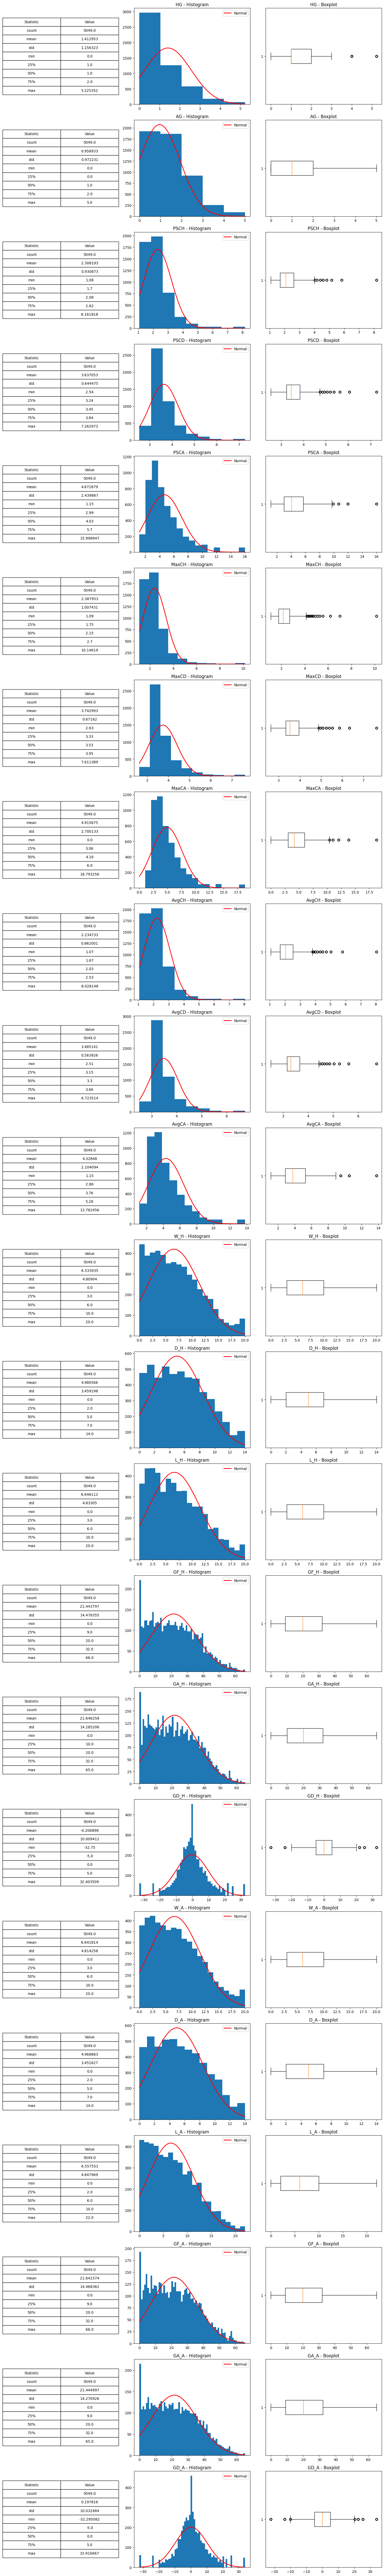

In [17]:
da = df.copy()
# numerical_columns = list(set(da.columns.to_list()) - set(categorical_data))

for col in numerical_df.columns:
    da[col] = da[col].astype(np.float64)

    num_bins = freedman_diaconis_rule(da[col], boxplots[col]["AIQ"])
    value_bins = pd.qcut(da[col], num_bins, duplicates="drop").value_counts()

    # Saving the intervals
    bin_dict = {}
    for interval, count in value_bins.items():
        bin_dict[(interval.left, interval.right)] = {"count": count, "avg": 0}

    # Adding each value into the correct interval
    for value in da[col]:
        for (left, right) in bin_dict:
            if left < value and value <= right: 
                bin_dict[(left, right)]["avg"] += value
                break

    # Calculating the average value of the bin
    for key in bin_dict.keys():
        if bin_dict[key]["count"] != 0:
            bin_dict[key]["avg"] = bin_dict[key]["avg"] / bin_dict[key]["count"]
    
    # Replacing outliers with bin average
    for idx, value in da[col].items():
        if value > boxplots[col]["max"] or value < boxplots[col]["min"]:
            for (left, right), data in bin_dict.items():
                if left < value and value <= right:
                    da.at[idx, col] = data["avg"]
                    break
    
describe_histogram_boxplot(da[numerical_df.columns])
print("")

O qcut foi escolhido para aproximar os outliers que estão muito longe dos dados normais, suavizando-os.

Os outliers foram suavizados e, àqueles que possuiam valores muito discrepantes, foram reduzidos significativamente, como ocorreu nos dados do MaxCH, onde passaram de 29 para 10, por exemplo, ficando extremamente mais próximos dos demais valores do atributo.

Além disso, em alguns dados, como no AG, não há mais a presença de outliers, demonstrando a eficiência do qcut.

No GD_A e no GD_H, os outliers ainda estão bem presentes. Mesmo sendo suavizados, passando de -56 para -32, por exemplo, a grande presença dos mesmos nos valores mais extremos ainda deixou os dados com bastantes valores aberrantes, ainda sendo notável uma grande presença deles nos extremos.


## c) Resolvendo inconsistênicas
Não há mais inconsistências nos dados, uma vez que a partida que apresentava já foi removida

## d) Transformando atributos categóricos nominais em vetores numéricos

In [18]:
df = pd.get_dummies(df, columns=["Res"], prefix="Res", dtype=int, drop_first=True) # Transformando em on-hot-encoded

df = df.drop(["Season"], axis=1) # It is a numerical data, but it does not represent very useful information, since the season statistics are already incorporated in the last columns of the table

df = df.drop(["Home", "Away"], axis=1) # Numerical data that does not reveal relevant information at the moment

df = df.drop(["HG", "AG"], axis=1) # I won't know how many goals each team will score in the match when I predict the result, so it's an attribute that only served to build other statistical attributes

# e) Transformação de atributos categóricos ordinais
Não há atributos categóricos ordinais nos dados

# f) Normalização de valores numéricos.

In [20]:
# min-max normalization
numerical_columns = list(set(da.columns.to_list()) - set(categorical_data) - set(["HG", "AG"]))
df[numerical_columns] = (df[numerical_columns] - df[numerical_columns].min()) / (df[numerical_columns].max() - df[numerical_columns].min())

df


PSCH      PSCD      PSCA     MaxCH     MaxCD     MaxCA     AvgCH  \
0     0.040361  0.135942  0.144214  0.024006  0.125633  0.147500  0.032359   
1     0.105422  0.087539  0.053816  0.062343  0.080041  0.075000  0.079332   
2     0.031325  0.154480  0.195920  0.020781  0.143870  0.200556  0.027140   
3     0.084940  0.083419  0.070348  0.050161  0.077001  0.087500  0.066806   
4     0.053012  0.101957  0.114668  0.031172  0.091185  0.122500  0.042797   
...        ...       ...       ...       ...       ...       ...       ...   
5045  0.038554  0.089598  0.173408  0.024006  0.099291  0.182500  0.033403   
5046  0.015663  0.263646  0.320084  0.010749  0.250253  0.291667  0.014614   
5047  0.119277  0.042225  0.055223  0.075958  0.033435  0.075556  0.103340   
5048  0.065663  0.058702  0.099894  0.041920  0.063830  0.110833  0.056889   
5049  0.029518  0.136972  0.209286  0.017556  0.133739  0.209722  0.025574   

         AvgCD     AvgCA       W_H       D_H       L_H    GF_H      GA_H  \
0     0.119134  0.147464  0.000000  0.000000  0.000000  0.0000  0.000000   
1     0.086643  0.056233  0.000000  0.000000  0.000000  0.0000  0.000000   
2     0.139591  0.176563  0.000000  0.000000  0.000000  0.0000  0.000000   
3     0.090253  0.066457  0.000000  0.000000  0.000000  0.0000  0.000000   
4     0.098676  0.107747  0.000000  0.000000  0.000000  0.0000  0.000000   
...        ...       ...       ...       ...       ...     ...       ...   
5045  0.099880  0.185608  0.148148  0.117647  0.142857  0.1500  0.177215   
5046  0.285199  0.324420  0.222222  0.176471  0.035714  0.2375  0.050633   
5047  0.045728  0.058199  0.222222  0.117647  0.071429  0.1875  0.088608   
5048  0.068592  0.101848  0.074074  0.294118  0.107143  0.1500  0.177215   
5049  0.155235  0.222572  0.148148  0.176471  0.107143  0.1375  0.063291   

          GD_H       W_A       D_A       L_A      GF_A   GA_A      GD_A  \
0     0.547170  0.000000  0.000000  0.000000  0.000000  0.000  0.513761   
1     0.547170  0.000000  0.000000  0.000000  0.000000  0.000  0.513761   
2     0.547170  0.000000  0.000000  0.000000  0.000000  0.000  0.513761   
3     0.547170  0.000000  0.000000  0.000000  0.000000  0.000  0.513761   
4     0.547170  0.000000  0.000000  0.000000  0.000000  0.000  0.513761   
...        ...       ...       ...       ...       ...    ...       ...   
5045  0.528302  0.071429  0.176471  0.185185  0.116279  0.175  0.477064   
5046  0.688679  0.071429  0.235294  0.148148  0.116279  0.125  0.513761   
5047  0.622642  0.250000  0.058824  0.074074  0.127907  0.075  0.559633   
5048  0.528302  0.178571  0.117647  0.111111  0.151163  0.150  0.522936   
5049  0.603774  0.142857  0.176471  0.111111  0.127907  0.100  0.541284   

      Res_D  Res_H  
0         1      0  
1         1      0  
2         0      1  
3         0      1  
4         0      0  
...     ...    ...  
5045      1      0  
5046      0      1  
5047      0      1  
5048      0      0  
5049      0      1  

[5049 rows x 23 columns]